# Sample Functions for Analysis

In [27]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import nltk
from nltk.collocations import *

import networkx as nx
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Preparations

In [8]:
# load data
filepath="/Users/rachelker/Documents/UChic MSCAPP/Curriculum/2019-20 Winter/Computational Content Analysis/Project/twitterpolicydiscourse/data/"
coca_data = pd.read_csv(filepath + "refugee_coca_foranalysis.csv")
#tweet_data = 

In [9]:
len(coca_data)

3992

In [10]:
# to concatenate coca and tweet data
data = coca_data

In [11]:
# tokenize and normalize words
data['tokenized_words'] = data['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
data['normalized_words'] = data['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
data['normalized_words_POS'] = [lucem_illud_2020.spacy_pos(t) for t in data['text']]


# tokenize and normalize sentences
data['tokenized_sents'] = data['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [12]:
data.to_csv("data/refugee_coca_normalized.csv", index=False)

In [51]:
data[:5]

,text_id,text,word_count,year,genre,subgen,source,title,publication_info,tokenized_words,normalized_words,normalized_words_POS,tokenized_sents,normalized_sents
0,2018849,""" bums . "" that 's what radio havana called ...",2950,1990,MAG,124.0,Money,This is the land of opportunity.,"Vol. 19 Issue 8, p98, 8p, 1 chart, 3c, 4bw\r\n","[bums, that, 's, what, radio, havana, called, ...","[bum, radio, havana, call, cubans, flee, u.s, ...","[( , _SP), ("", ``), (bums, NNS), (., .), ("", ...","[[bums], [that, 's, what, radio, havana, calle...","[[bum], [radio, havana, call], [cubans, flee, ..."
1,2018850,section : investing expanding petrochemical ...,2514,1990,MAG,124.0,Money,Betting on regional booms.,"Vol. 19 Issue 8, p110, 5p, 1 chart, 2c\r\n","[section, investing, expanding, petrochemical,...","[section, invest, expand, petrochemical, plant...","[( , _SP), (section, NN), (:, :), (investing, ...","[[section, investing, expanding, petrochemical...","[[section, invest, expand, petrochemical, plan..."
2,2019006,section : clothes that work american history ...,1667,1990,MAG,130.0,MotherEarth,The evolution of jeans.,"p60, 4p, 5c, 2bw\r\n","[section, clothes, that, work, american, histo...","[section, clothe, work, american, history, sam...","[( , _SP), (section, NN), (:, :), (clothes, NN...","[[section], [clothes, that, work, american, hi...","[[section], [clothe, work, american, history, ..."
3,2019061,section : movements from socialist to republi...,1754,1990,MAG,123.0,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n","[section, movements, from, socialist, to, repu...","[section, movement, socialist, republicans, ge...","[( , _SP), (section, NN), (:, :), (movements, ...","[[section], [movements, from, socialist, to, r...","[[section], [movement, socialist, republicans,..."
4,2019063,inside a dusty cement-block house with worn ...,6032,1990,MAG,123.0,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n","[inside, a, dusty, cement, block, house, with,...","[inside, dusty, cement, block, house, wear, li...","[( , _SP), (inside, IN), (a, DT), (dusty, JJ)...","[[inside, a, dusty, cement, block, house, with...","[[inside, dusty, cement, block, house, wear, l..."


## Word/Phrase Frequency

In [16]:
# get context
post_text = nltk.Text(data['tokenized_words'].sum())
index = nltk.text.ConcordanceIndex(post_text) 

In [17]:
index.print_concordance('refugee')

Displaying 25 of 3582 matches:
university and himself a 1960 cuban refugee mariels were driven less by politic
he wall photo black white below the refugee center where the suarezes and other
toon at second glance i look like a refugee farmer but careful examination reve
s guerrillas as we pass a family of refugee indians from the highlands dressed 
ople creating a massive and complex refugee problem half a million saudis egypt
tuation is of particular concern to refugee organizations if baghdad succeeds i
 an unusual briefing on the kuwaiti refugee dilemma and the palestinian aspect 
no one knows how many soviet jewish refugee immigrants will finally come in par
at they had better shut down contra refugee camps before michael dukakis became
d cutting why not the fanjuls are a refugee family he says the economy of the c
ttee on the panama canal the aid to refugee chinese intellectuals among the bet
ms fell over themselves to hire any refugee from drexel 's corporate finance de
soviet ar

In [18]:
index.print_concordance('refugees')

Displaying 25 of 7256 matches:
w in the water jammed with 80 or so refugees some of them just released from cub
torm a documentary about the mariel refugees fate as he gazes at the hangar the 
hter 's future making a will mariel refugees belies the stigma that the cuban bo
ift 's end in september some mariel refugees had committed murders burglaries or
where the suarezes and other mariel refugees section investing expanding petroch
uments and aerospace parts many are refugees from high tax california and unfort
tytown later they met three teenage refugees from honduras the last surviving ma
y center casa oscar romero when the refugees brought out guitars the students le
ese newer immigrants were political refugees they were for the most part poor pe
,744 people mostly eastern european refugees then living in germany and austria 
gulations provided for thousands of refugees from hungary after the hungarian ri
ericans including relatively recent refugees or emigres or escapees from easte

In [19]:
# common context
post_text.common_contexts(['refugees'])

so_some mariel_fate mariel_belies mariel_had mariel_section are_from
teenage_from the_brought political_they european_then of_from
recent_or of_in servants_who other_say asian_from for_reported
kuwaiti_most 60,000_crossed new_as


/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded " "(please install Tkinter library).")


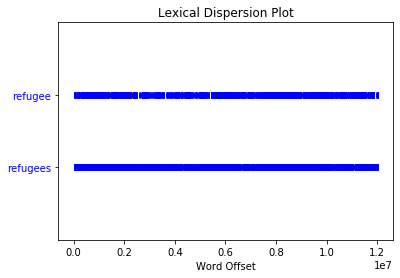

In [20]:
#Lexical Dispersion Plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
post_text.dispersion_plot(['refugee', 'refugees'])
sns.set() #Re-enabling seaborn

In [39]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)

In [45]:
freq[:20]

,count
say,49565
people,36155
think,30895
go,28799
year,27061
know,26441
mr,25620
time,22330
come,21985
like,21222


In [54]:
#Most common POS
def get_most_common_POS(data, years, genre=None):
    for yr in years:
        if genre:
            yearly = data[(data['genre']==genre) & (data['year']==yr)]
        else:
            yearly = data[data['year']==yr]
        freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in yearly['normalized_words_POS'].sum())
        print(yr)
        print("Most Common Nouns")
        print(freqdist_POStoWord['NN'].most_common(10))
        print()
        print("Most Common Adj")
        print(freqdist_POStoWord['JJ'].most_common(10))
        print()
        print("Most Common Verbs")
        print(freqdist_POStoWord['VB'].most_common(10))
        print()

In [55]:
years = sorted(data['year'].unique())
get_most_common_POS(data, years)

1990
Most Common Nouns
[('time', 980), ('government', 940), ('today', 874), ('world', 802), ('country', 781), ('war', 687), ('way', 665), ('year', 610), ('day', 460), ('money', 420)]

Most Common Adj
[('other', 1195), ('many', 820), ('new', 762), ('american', 638), ('last', 600), ('good', 573), ('iraqi', 571), ('military', 518), ('first', 513), ('soviet', 481)]

Most Common Verbs
[('be', 3589), ('have', 1334), ('do', 853), ('get', 709), ('go', 560), ('think', 486), ('take', 482), ('make', 476), ('say', 455), ('see', 407)]

1991
Most Common Nouns
[('war', 1349), ('time', 1282), ('government', 1106), ('today', 1071), ('country', 925), ('way', 893), ('world', 790), ('year', 703), ('day', 602), ('problem', 559)]

Most Common Adj
[('other', 1437), ('many', 1073), ('iraqi', 849), ('american', 841), ('new', 832), ('last', 810), ('good', 767), ('first', 687), ('political', 653), ('own', 568)]

Most Common Verbs
[('be', 4783), ('have', 1995), ('do', 1254), ('get', 888), ('go', 874), ('say', 709

2006
Most Common Nouns
[('time', 756), ('world', 485), ('day', 474), ('government', 461), ('country', 460), ('way', 453), ('today', 417), ('war', 382), ('year', 376), ('city', 374)]

Most Common Adj
[('other', 669), ('many', 629), ('new', 586), ('last', 414), ('israeli', 399), ('first', 386), ('old', 354), ('good', 325), ('american', 310), ('little', 284)]

Most Common Verbs
[('be', 2140), ('have', 812), ('get', 546), ('do', 510), ('see', 395), ('go', 387), ('take', 368), ('make', 327), ('say', 262), ('come', 250)]

2007
Most Common Nouns
[('time', 537), ('war', 467), ('government', 419), ('world', 401), ('year', 395), ('country', 336), ('way', 331), ('today', 327), ('life', 310), ('day', 298)]

Most Common Adj
[('other', 493), ('many', 410), ('new', 392), ('last', 295), ('first', 287), ('american', 278), ('good', 248), ('political', 227), ('own', 216), ('old', 209)]

Most Common Verbs
[('be', 1640), ('have', 715), ('do', 473), ('get', 349), ('go', 293), ('make', 269), ('see', 255), ('

In [56]:
genre = 'MAG'
genre_years = sorted(data[data['genre']==genre]['year'].unique())
get_most_common_POS(data, genre_years, genre)

1990
Most Common Nouns
[('time', 219), ('year', 205), ('world', 181), ('state', 149), ('city', 144), ('photo', 144), ('government', 141), ('country', 128), ('family', 119), ('money', 117)]

Most Common Adj
[('other', 254), ('new', 221), ('many', 201), ('such', 159), ('american', 157), ('first', 126), ('old', 123), ('own', 123), ('last', 117), ('foreign', 114)]

Most Common Verbs
[('be', 678), ('have', 224), ('do', 116), ('get', 99), ('take', 89), ('make', 80), ('see', 74), ('go', 72), ('keep', 51), ('come', 44)]

1991
Most Common Nouns
[('time', 231), ('war', 152), ('world', 150), ('year', 133), ('photo', 116), ('way', 103), ('day', 102), ('man', 95), ('government', 92), ('country', 87)]

Most Common Adj
[('other', 209), ('new', 161), ('first', 153), ('many', 147), ('last', 145), ('old', 141), ('american', 122), ('own', 111), ('few', 103), ('little', 99)]

Most Common Verbs
[('be', 474), ('have', 201), ('do', 107), ('get', 89), ('take', 80), ('make', 79), ('go', 73), ('come', 62), ('se

2009
Most Common Nouns
[('time', 120), ('war', 105), ('family', 99), ('life', 93), ('way', 90), ('mother', 79), ('world', 79), ('show', 78), ('idf', 71), ('church', 68)]

Most Common Adj
[('other', 109), ('many', 102), ('new', 88), ('israeli', 80), ('good', 79), ('jewish', 71), ('first', 69), ('own', 63), ('old', 60), ('little', 59)]

Most Common Verbs
[('be', 295), ('have', 118), ('do', 65), ('make', 60), ('get', 53), ('say', 51), ('see', 50), ('know', 44), ('take', 37), ('go', 29)]

2010
Most Common Nouns
[('time', 207), ('year', 153), ('wife', 143), ('war', 124), ('-', 112), ('world', 104), ('mail', 102), ('class', 101), ('life', 96), ('climate', 91)]

Most Common Adj
[('many', 144), ('other', 139), ('new', 137), ('last', 125), ('first', 109), ('good', 82), ('few', 79), ('old', 75), ('great', 72), ('next', 64)]

Most Common Verbs
[('be', 400), ('have', 116), ('do', 63), ('make', 62), ('get', 62), ('see', 55), ('take', 53), ('go', 46), ('know', 37), ('work', 35)]

2011
Most Common No

In [57]:
genre = 'SPOK'
genre_years = sorted(data[data['genre']==genre]['year'].unique())
get_most_common_POS(data, genre_years, genre)

1990
Most Common Nouns
[('today', 699), ('government', 630), ('time', 625), ('country', 539), ('world', 506), ('way', 466), ('war', 448), ('-', 333), ('lot', 306), ('fact', 295)]

Most Common Adj
[('other', 714), ('many', 430), ('good', 417), ('new', 392), ('american', 361), ('last', 359), ('military', 349), ('iraqi', 334), ('soviet', 310), ('first', 276)]

Most Common Verbs
[('be', 2407), ('have', 974), ('do', 636), ('get', 524), ('think', 424), ('go', 422), ('say', 374), ('make', 330), ('let', 324), ('take', 306)]

1991
Most Common Nouns
[('war', 951), ('today', 893), ('time', 870), ('government', 755), ('country', 707), ('way', 646), ('world', 493), ('question', 461), ('president', 461), ('m', 457)]

Most Common Adj
[('other', 940), ('many', 632), ('good', 625), ('iraqi', 579), ('american', 553), ('last', 514), ('new', 489), ('first', 401), ('political', 394), ('military', 374)]

Most Common Verbs
[('be', 3613), ('have', 1593), ('do', 1030), ('get', 715), ('go', 713), ('think', 628)

2007
Most Common Nouns
[('time', 274), ('today', 227), ('war', 226), ('government', 196), ('way', 179), ('lot', 159), ('king', 152), ('world', 144), ('something', 140), ('year', 139)]

Most Common Adj
[('other', 240), ('many', 187), ('american', 150), ('good', 144), ('new', 137), ('last', 134), ('political', 123), ('iraqi', 97), ('same', 95), ('off', 92)]

Most Common Verbs
[('be', 840), ('have', 447), ('do', 290), ('get', 206), ('go', 179), ('think', 153), ('see', 148), ('say', 145), ('know', 139), ('make', 132)]

2008
Most Common Nouns
[('today', 109), ('time', 93), ('hemmer', 93), ('footage', 89), ('government', 81), ('lot', 59), ('health', 57), ('money', 54), ('part', 53), ('way', 52)]

Most Common Adj
[('many', 95), ('other', 70), ('new', 67), ('good', 65), ('last', 46), ('american', 41), ('big', 39), ('same', 38), ('little', 34), ('much', 31)]

Most Common Verbs
[('be', 322), ('have', 129), ('do', 95), ('get', 91), ('go', 74), ('say', 71), ('see', 63), ('let', 61), ('make', 60), 

In [58]:
genre = 'NEWS'
genre_years = sorted(data[data['genre']==genre]['year'].unique())
get_most_common_POS(data, genre_years, genre)

1990
Most Common Nouns
[('government', 169), ('time', 136), ('war', 128), ('today', 118), ('world', 115), ('year', 115), ('country', 114), ('city', 105), ('life', 93), ('money', 90)]

Most Common Adj
[('other', 227), ('iraqi', 191), ('many', 189), ('new', 149), ('last', 124), ('old', 122), ('-', 121), ('american', 120), ('first', 111), ('soviet', 108)]

Most Common Verbs
[('be', 504), ('have', 136), ('do', 101), ('take', 87), ('get', 86), ('make', 66), ('go', 66), ('help', 58), ('know', 52), ('see', 44)]

1991
Most Common Nouns
[('government', 259), ('war', 246), ('%', 195), ('time', 181), ('year', 170), ('border', 148), ('world', 147), ('way', 144), ('peace', 133), ('country', 131)]

Most Common Adj
[('many', 294), ('other', 288), ('iraqi', 256), ('new', 182), ('american', 166), ('political', 164), ('kurdish', 159), ('last', 151), ('first', 133), ('military', 125)]

Most Common Verbs
[('be', 696), ('have', 201), ('do', 117), ('go', 88), ('take', 86), ('get', 84), ('make', 83), ('see',

2006
Most Common Nouns
[('time', 160), ('city', 160), ('year', 143), ('government', 138), ('family', 131), ('war', 110), ('percent', 106), ('country', 103), ('day', 102), ('market', 93)]

Most Common Adj
[('many', 217), ('other', 207), ('new', 182), ('israeli', 152), ('last', 122), ('palestinian', 117), ('first', 115), ('old', 113), ('american', 79), ('local', 70)]

Most Common Verbs
[('be', 476), ('have', 114), ('do', 95), ('get', 80), ('go', 69), ('take', 68), ('make', 66), ('help', 54), ('see', 45), ('know', 40)]

2007
Most Common Nouns
[('time', 117), ('government', 110), ('year', 104), ('family', 90), ('life', 89), ('school', 84), ('city', 83), ('war', 78), ('world', 72), ('country', 71)]

Most Common Adj
[('new', 113), ('many', 96), ('other', 91), ('first', 87), ('last', 73), ('high', 65), ('former', 55), ('political', 54), ('iraqi', 52), ('arab', 50)]

Most Common Verbs
[('be', 338), ('have', 116), ('do', 65), ('make', 62), ('get', 62), ('go', 61), ('take', 38), ('help', 36), ('

In [ ]:
#Word Cloud
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(data['normalized_words'].sum()))
    plt.imshow(wc)
    plt.axis("off")
    wc.to_file('wordcloud/data_{}.png'.format(yr))

In [62]:
# collocations
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    
    data_bigrams = nltk.collocations.BigramCollocationFinder.from_words(words)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    print(yr)
    print(data_bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:5])
    
    data_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(words)
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    print(data_trigrams.score_ngrams(trigram_measures.likelihood_ratio)[:5])
    
# other options include student_t, chi_sq, likelihood_ratio, pmi

1990
[(('unite', 'state'), 7199.697459742365), (('mr', 'macneil'), 5182.843636580887), (('saddam', 'hussein'), 5124.447968424104), (('mr', 'lehrer'), 4829.11002234646), (('saudi', 'arabia'), 4583.479938021688)]
[(('unite', 'state', 'baker'), 11075.771911269172), (('ambassador', 'unite', 'state'), 11068.928726036236), (('unite', 'state', 'soviet'), 10892.836049392063), (('unite', 'state', 'government'), 10874.341495944747), (('unite', 'state', 'impose'), 10844.911026837526)]
1991
[(('unite', 'state'), 8589.98210113935), (('saddam', 'hussein'), 7472.851549691972), (('mr', 'macneil'), 5550.671758042515), (('mr', 'lehrer'), 5016.541191503217), (('soviet', 'union'), 4138.521090510931)]
[(('unite', 'state', 'baker'), 13155.048049326459), (('president', 'unite', 'state'), 13047.280788762055), (('unite', 'state', 'america'), 12968.576770184256), (('ambassador', 'unite', 'state'), 12961.201633555607), (('unite', 'state', 'senate'), 12948.304813605911)]
1992
[(('unite', 'state'), 4038.4528809802

[(('new', 'york'), 1258.2633966990845), (('unite', 'state'), 1247.6715415649314), (('barack', 'obama'), 710.7214549763021), (('hillary', 'clinton'), 679.0065412618319), (('video', 'clip'), 610.2734742756992)]
[(('new', 'york', 'city'), 2026.2782358261818), (('new', 'york', 'time'), 1988.9611565109817), (('envirosell', 'new', 'york'), 1948.6344010275116), (('new', 'york', 'state'), 1934.0946829286238), (('new', 'york', 'new'), 1918.1534597488114)]
2009
[(('unidentified', 'male'), 1536.1339905184982), (('jim', 'lehrer'), 1510.3308332477857), (('mankiewicz', 'voiceover'), 1380.2657822848687), (('unite', 'state'), 1097.6009806112102), (('amanpour-1voice', 'o'), 963.7690309676445)]
[(('unidentified', 'male', 'translator'), 3062.3302760329925), (('break', 'jim', 'lehrer'), 2535.7659358821043), (('unidentified', 'male', 'yes'), 2462.2438331700037), (('yes', 'unidentified', 'male'), 2362.3551690150366), (('be', 'jim', 'lehrer'), 2359.9697691764427)]
2010
[(('e', 'mail'), 1638.4307997254743), (

## Calculating Divergence

In [ ]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [ ]:
def plot_div_heatmap(corpora, fileids, diff_measure='KL'):
    '''
    Diff measure = KL, Chi2, KS or Wasserstein
    '''
    L = []
    for p in corpora:
        l = []
        for q in corpora:
            l.append(Divergence(p,q, difference = diff_measure))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pandas.DataFrame(M, columns = fileids, index = fileids)
    ax = sns.heatmap(div)
    plt.show()

In [ ]:
# TO CHECK
corpora = data['normalized_words'][:2].sum()
# corpora = []
# for index, row in data.iterrows():
#     corpora.append(row['tokenized_words'])
fileids = list(data['text_id'][:2])
plot_div_heatmap(corpora, fileids,diff_measure='KL')

## Word Networks

In [73]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

def plot_word_graph(graph):
    layout = nx.spring_layout(graph, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    nx.draw(graph, ax = ax, pos = layout, labels = {n:n for n in graph.nodes()},
            width=.2, 
            alpha = .9, 
            node_size = 100,
            node_color = "xkcd:light red",
            edge_color='xkcd:black')

def plot_word_centrality(g):
    layout_nn = nx.spring_layout(g, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    centralities_nn = nx.eigenvector_centrality(g)
    maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
    #maxWeight = max((d['weight'] for n1, n2, d in g.edges(data = True)))
    #minWeight = min((d['weight'] for n1, n2, d in g.edges(data = True)))
    nx.draw(g, ax = ax, pos = layout_nn, labels = {n: n for n in g.nodes()},
            #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
            alpha = .9, 
            node_color = [centralities_nn[n] / maxC for n in g.nodes],
            node_size = [centralities_nn[n] / maxC * 100 for n in g.nodes],
            font_size = 16,
            font_color = 'xkcd:dark grey',
            edge_color = 'xkcd:medium blue',
            cmap = plt.get_cmap('plasma'),
           )

### plot word network

In [ ]:
# plot word network
g = wordCooccurrence(data['normalized_sents'].sum())
len(g)

In [ ]:
weight_choice = 25
# remove if less than 25
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= weight_choice])
#since we are changing the graph list() evaluates the isolates first
g.remove_nodes_from(list(nx.isolates(g)))
# keep just the giant connected component
main_graph = max(connected_component_subgraphs(g), key=len)
print(nx.info(main_graph))

In [ ]:
plot_word_graph(main_graph)

In [ ]:
# plot sub-graph
immigrant_neighbors = main_graph.neighbors('family')
subgraph_immigrant = main_graph.subgraph(immigrant_neighbors)
print(nx.info(subgraph_immigrant))

plot_word_graph(subgraph_immigrant)

In [ ]:
# cliques
print(', '.join(max(nx.clique.find_cliques(main_graph), key = lambda x: len(x))))

### plot word network by pos

In [ ]:
# plot pos network
gNV = posCooccurrence(data['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV))

In [ ]:
degree_threshold= 100
weight_threshold = 2
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= degree_threshold]) 
print(nx.info(gNV))
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= weight_threshold])
print(nx.info(gNV))

In [ ]:
#TO CHECK
plot_word_centrality(gNV)

In [ ]:
# draw egocentric network
g_immigrant_NV = gNV.subgraph(['family'] + list(gNV.neighbors('family')))
print(nx.info(g_immigrant_NV))

In [ ]:
nx.draw_networkx(g_immigrant_NV)

### centrality & global measures

In [ ]:
#centralities

centralities = nx.degree_centrality(main_graph)
#centralities = nx.eigenvector_centrality(main_graph)
#centralities = nx.closeness_centrality(main_graph)
#centralities = nx.betweenness.betweenness_centrality(main_graph)
plt.hist(list(centralities.values()))
plt.show()

In [ ]:
name = 'degree'

centrality_df = pandas.DataFrame.from_dict(centralities, orient='index', columns=[name])
centrality_df.sort_values(by=name, ascending=False, inplace=True)
#highest 10
centrality_df[:10]

In [ ]:
#global measures
density = nx.density(main_graph)
mean_degree_pernode = np.mean([v for w,v in nx.degree(main_graph)])
diameter = nx.diameter(main_graph)
print(
"The density of this graph is {}\n\
Mean degree per node is {}\n\
Diameter of graph is {}".format(density, mean_degree_pernode, diameter))

## Clustering

In [ ]:
# TFIDF vectoriser
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])

In [ ]:
def find_best_n(X, max=10):
    clusters = []
    s_avg = []
    for i in range(2, max):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        clusters.append(i)
        s_avg.append(silhouette_avg)
        print("For {} clusters, average silhouette score is {}".format(i, silhouette_avg))
    plt.plot(clusters, s_avg)
    plt.show()

X = dataVects.toarray()
find_best_n(X)

In [ ]:
num_cluster = 5
km = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')
km.fit(dataVects)
data['kmeans_prediction'] = km.labels_

In [ ]:
def get_top_words(km, num_cluster, data_vectoriser):
    terms = data_vectoriser.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(num_cluster):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind])
        print('\n')

get_top_words(km, num_cluster, data_vectoriser)

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    
    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")    
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

In [ ]:
plotSilhouette(num_cluster, X)

In [ ]:
def plot_clusters(dataVects, km, num_cluster, terms=data_vectoriser.get_feature_names()):
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    # get distinguishing words to label
    components = pca.components_
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
    words = [terms[i] for i in keyword_ids]#Turn the ids into words.
    x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
    y = components[:,keyword_ids][1,:]
    
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors_p = [cmap(l/num_cluster) for l in km.labels_]
    
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))
    plt.xticks(())
    plt.yticks(())
    plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
    plt.show()

In [ ]:
plot_clusters(dataVects, km, num_cluster)

## Topic Modelling

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [ ]:
# creating dictionary
dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]
# serialize
gensim.corpora.MmCorpus.serialize('data.mm', corpus)
data_mm = gensim.corpora.MmCorpus('data.mm')
# topic modelling
topics=10
data_lda = gensim.models.ldamodel.LdaModel(corpus=data_mm, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')

In [ ]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:10][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pandas.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title):
    N = 10
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

In [ ]:
title = "topics relevant to immigra in first 10 documents"
plot_topics(data_lda, dictionary, data, title, n=10)

In [ ]:
data_lda.show_topic(5, topn=10)

In [ ]:
#dynamic topic modelling - long run time (overnight)
#docs_per_year = list(data.groupby('year').size())
#num_topics = 4
#data_ldaseq = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

In [ ]:
#data_ldaseq.save("data_ldaseq")

In [ ]:
#newspaper_ldaseq.print_topics(time=0)

In [ ]:
#topic distribution divergence

from gensim.matutils import kullback_leibler

def plot_topic_divergence(data, years, num_topics=5):
    topic_prob = get_topic_prob(data, years, num_topics)
    L = []
    for year_1 in topic_prob.keys():
        p = topic_prob[year_1]
        l = []
        for year_2 in topic_prob.keys():
            q = topic_prob[year_2]
            l.append(kullback_leibler(p, q))
        L.append(l)
    M = np.array(L)

    fig = plt.figure()
    div = pandas.DataFrame(M, columns = list(topic_prob.keys()), index = list(topic_prob.keys()))
    ax = sns.heatmap(div)
    plt.show()
    
def get_topic_prob(data, years, num_topics=5):
    topic_prob = {}
    
    byyear = get_topic_distribution(data, years, num_topics)
    # Convert to probability
    for yr in years:
        j=0
        for i in range(10):
            try:
                index, prob = byyear[yr][j]
            except IndexError:
                index = False

            if index == i:
                j+=1
                if yr in topic_prob:  
                    topic_prob[yr].append(prob)
                else:
                    topic_prob[yr] = [prob]
            else:
                if yr in topic_prob:  
                    topic_prob[yr].append(float(0))
                else:
                    topic_prob[yr] = [float(0)]
    return topic_prob


def get_topic_distribution(data, years, num_topics=5):
    byyear = {}
    # Get topic distribution for each year
    for yr in years:
        # get all text for each year
        text_df = data[data['year']==yr][['text']]
        text_df['tokenized_text'] = text_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
        text_df['normalized_tokens'] = text_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
        # create dictionary
        data_dictionary_byyear = gensim.corpora.Dictionary(text_df['normalized_tokens'])
        data_corpus_byyear = [data_dictionary_byyear.doc2bow(text) for text in text_df['normalized_tokens']]
        #lda
        lda_byyear = gensim.models.ldamodel.LdaModel(corpus=data_corpus_byyear, id2word=data_dictionary_byyear, num_topics=num_topics, alpha='auto', eta='auto')

        # place topic distribution in dictionary
        all_text = []
        for text in text_df['normalized_tokens']:
            all_text.extend(text)
        byyear[yr] = lda_byyear[data_dictionary_byyear.doc2bow(all_text)]

        print('{} done'.format(yr))
    return byyear

In [ ]:
years = sorted(data['year'].unique())
plot_topic_divergence(data, years, num_topics=5)

## Word Embeddings

### word2vec

In [ ]:
data_w2v = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum())

In [ ]:
#data_w2v.save('data_w2v')

In [ ]:
data_w2v.most_similar(positive=['immigrants'])

In [ ]:
def plot_embeddings(data_w2v, numWords):
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [ ]:
plot_embeddings(data_w2v, 100)

### doc2vec

In [ ]:
def tag_docs(data):
    taggedDocs = []
    for index, row in data.iterrows():
        #Just doing a simple keyword assignment
        docKeywords = [row['year']]
        docKeywords.append(row['text_id'])
        docKeywords.append(row['genre'])
        docKeywords.append(row['title'])
        docKeywords.append(row['word_count'])
        taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
    return taggedDocs

data['tagged_docs'] = tag_docs(data)

In [ ]:
data_d2v = gensim.models.doc2vec.Doc2Vec(data['tagged_docs'],size=100)

In [ ]:
#data_d2v.save("data_d2v")

In [ ]:
data_d2v.most_similar(positive = ['immigrants','illegal'], negative = ['legal'], topn = 10)

In [ ]:
def most_similar_by_year(data_d2v,years):
    for yr in years:
        print(yr)
        print(data_d2v.most_similar( [ data_d2v.docvecs[yr] ], topn=5))
        print()

years = range(1990,2016)        
most_similar_by_year(data_d2v, years)

In [ ]:
genre = list(data['genre'].unique())       
most_similar_by_year(data_d2v, genre)

In [ ]:
def plot_similarity(data_d2v, targetDocs):
    heatmapMatrixD = []
    for tagOuter in targetDocs:
        column = []
        tagVec = data_d2v.docvecs[tagOuter].reshape(1, -1)
        for tagInner in targetDocs:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, data_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrixD.append(column)
    heatmapMatrixD = np.array(heatmapMatrixD)
    fig, ax = plt.subplots()
    hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
    cbar = plt.colorbar(hmap)

    cbar.set_label('cosine similarity', rotation=270)
    a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
    a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

    a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
    a = ax.set_yticklabels(targetDocs, minor=False)

In [ ]:
plot_similarity(data_d2v, list(data['year'].unique()))

In [ ]:
plot_similarity(data_d2v, list(data['genre'].unique()))

### change over time

In [ ]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
data_rawEmbeddings, data_comparedEmbeddings = compareModels(data, 'year')

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

def plot_divergence(targetWord, comparedEmbeddings):
    pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
    fig, ax = plt.subplots(figsize = (10, 7))
    sns.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
    ax.set_xlabel("Starting year")
    ax.set_ylabel("Final year")
    ax.set_ylabel("Final year")
    ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
    plt.show()

In [ ]:
plot_divergence('immigrants', data_comparedEmbeddings)

In [ ]:
plot_divergence('immigration', data_comparedEmbeddings)

In [ ]:
plot_divergence('mexico', data_comparedEmbeddings)

In [ ]:
plot_divergence('border', data_comparedEmbeddings)

In [ ]:
def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

data_wordDivergences = findMostDivergent(data_comparedEmbeddings)

In [ ]:
# most divergence
data_wordDivergences[:20]

In [ ]:
# least divergence
data_wordDivergences[-20:]